## Semester project 
### Predicted Bitcoin prices and returns with ML Algorithms
submited in partial fulfillment of the course "Python for Finance II" by

__Kirill Gusev 01429691__ 

__Lara Grein 12134930__


#### The objective:
The main idea behind the project is to construct the model which will be able to predict the direction of Bitcoin prices for the next day or week.
#### Process description:
1. Data collection
2. Preliminary analysis 
3. Model construction
<dt>3.a. Support vector machine <\dt>
<dt>3.b. Random forest regressor <\dt>
4. Interpretation of the outcomes 
5. Further research ideas 


In [61]:
#Importing the necesary packages 
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import seaborn as sns
from pylab import rcParams
import sklearn.metrics as metr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import supfunc as sp #supfunc is the package specialy written for the semster proiject

In [2]:
#Stilyzing the plots

%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 16,8

#### Importing the data 
We use in current project Bitcoin data. The dataset contains high frequency data (every minute) from __2021-01-01__ till __2022-07-29__. We use both minutely and daily data in the project. For this reason we use *resample* function for finding the daily data. All data was obatined from coinbase public client. Look *dataextract.py*  

In [3]:
#Importing the data
data = pd.DataFrame()
data = pd.read_csv("BTC_high_freq.csv",index_col="Date") 
#data["SPY"] = pdr.get_data_yahoo("SPY", start="17/09/2014")["Adj Close"]
data.index = pd.to_datetime(data.index)
#Obtaining the daily data from hf data
df = data.resample('d').last()


#### Sampling

In [4]:
df["Return"] = np.log(df["Close"]/df["Close"].shift()) 
#Find if there is NaN values
print(data.isna().sum())
print(df.isna().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Return    1
dtype: int64


There is no missing data. No additional data clearing is needed.

In [5]:
# defining two different data sets Price and returns 
price = df.Close
returns = (1+df.Return.dropna())*100
df[["Close","Return"]].describe()

,Close,Return
count,574.000000,573.000000
mean,42820.155279,-0.000376
std,11197.451914,0.040654
min,18948.890000,-0.167446
25%,35519.375000,-0.021972
50%,42374.000000,0.000083
75%,50004.495000,0.021782
max,67554.840000,0.178076


<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

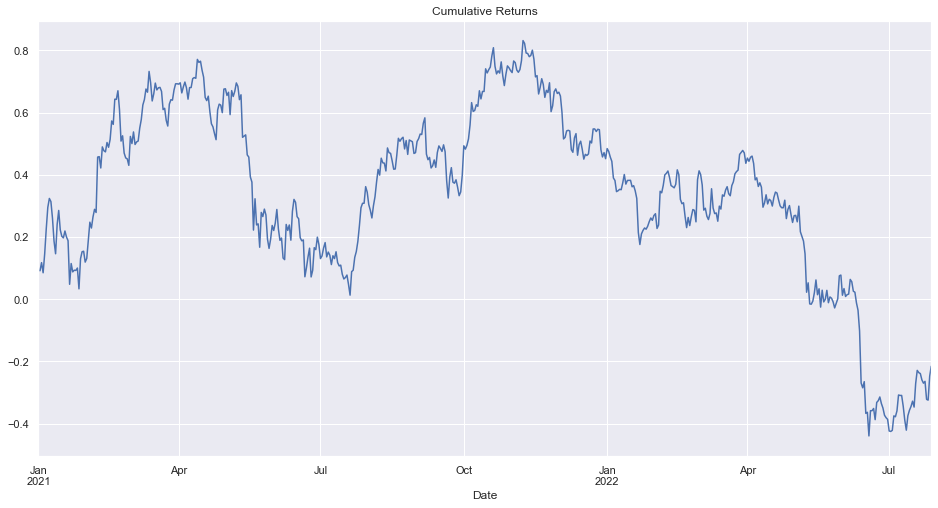

In [6]:
(df["Return"]).cumsum().plot(title='Cumulative Returns') #plotting cumulative Returns

#### Preliminary Analysis of the Data

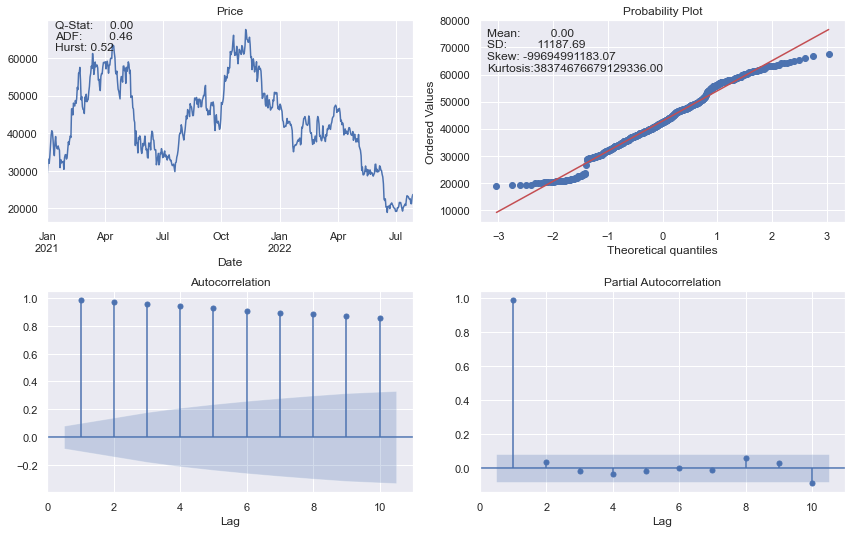

In [7]:
sp.plot_correlogram(price)

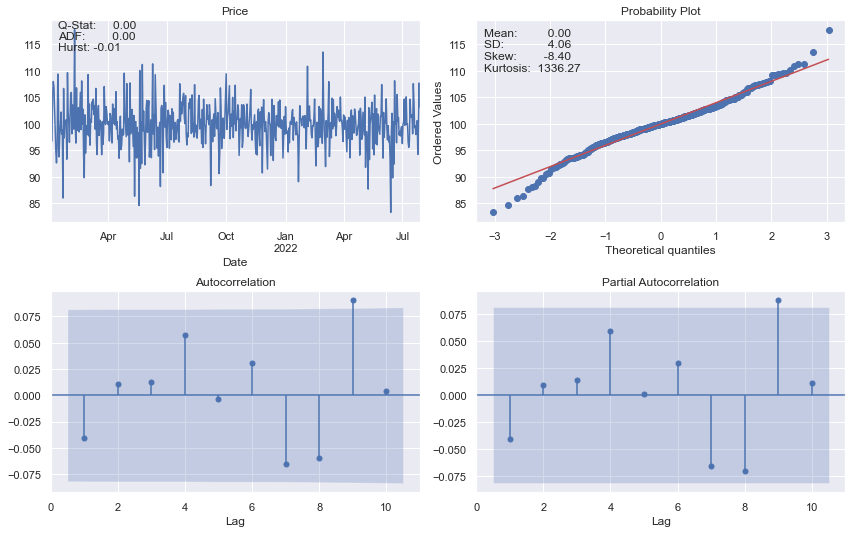

In [8]:
sp.plot_correlogram(returns)

As one can see from the graphs above Bitcoin price distribution doesn't reflect the normal distribution at all. Furthermore both autocorrelation and partial autocorrelation indicate that such models as ARIMA won't be helpfula at describing and predicting Bitcoin prices. 
The returns distribution do resamble normal distribution. However the autocorrelation and partial autorrelation graphs show that it will be quite challanging to find stastistical model.  

#### Model construction


##### Support vector machine learning algorithm
First we run the different models in order to find which one is the best in terms of different metrics mentioned in the next step. Here we trying to predict next day price/returns for the time span of one week with 180 days as a training data. Since the Bitcoin data is highly volatile and quite noisy we decided to use rolling window learning for all modells. The function works as follows:
1. Choose the time interval for prediction counted in the number of days __n__  
2. Choose how many days will be predicted in the one window 
3. We choose number of days for training sample - d
4. Choose the kernel for svr algo

In [9]:
n=7 #time interval for the prediction/ choose such n that n%p == 0 
p = 1 #one day prediction
d = 7 #number of rows in training sample 

#Price
l_v  = sp.svr_retrain(price,n=n,p=p,d=d,kernel='linear')
r_v = sp.svr_retrain(price,n=n,p=p,d=d,kernel='rbf')
p_v = sp.svr_retrain(price,n=n,p=p,d=d,kernel='poly')
s_v = sp.svr_retrain(price,n=n,p=p,d=d,kernel='sigmoid')


d = 180 #number of rows in training sample 
#Returns

l_r  = sp.svr_retrain(returns,n=n,p=p,d=d,kernel='linear')
r_r = sp.svr_retrain(returns,n=n,p=p,d=d,kernel='rbf')
p_r = sp.svr_retrain(returns,n=n,p=p,d=d,kernel='poly')
s_r = sp.svr_retrain(returns,n=n,p=p,d=d,kernel='sigmoid')

100%|██████████| 7/7 [00:00<00:00, 140.26it/s]


In order to distinguish btw the different models we use several metrics:
1. Mean Absolute Error
2. Mean Squared Error
3. Root Mean Squared Error
4. R squared
5. Accuracy 
6. Mean Absolute Percantage Error 

In [10]:
#Creating the DataFrame Metrics
base_p = [l_v,r_v,p_v,s_v]
base_r = [l_r,r_r,p_r,s_r]

a = pd.DataFrame(columns = ["Pr linear","Pr rbf","Pr poly","Pr sigmoid"])
b = pd.DataFrame(columns = ["Ret linear","Ret rbf","Ret poly","Ret sigmoid"])

for j in range(4):
    a[a.columns[j]] = sp.metrics(base_p[j],price.iloc[-n:])[0]
    b[b.columns[j]] = sp.metrics(base_r[j],returns.iloc[-n:])[0]

stat_metr = pd.concat([a,b],axis=1)

stat_metr.T


,Mean Absolute Prct Error,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,(R squared) Score,Accuracy
Pr linear,3.515,17716.0,4.827325e+08,21971.0,-0.5,-2.515
Pr rbf,0.045,1011.0,1.737418e+06,1318.0,-3.5,0.955
Pr poly,1.001,4498708.0,3.416863e+13,5845394.0,-0.5,-0.001
Pr sigmoid,0.040,906.0,1.124347e+06,1060.0,-7.2,0.960
Ret linear,0.030,3.0,1.400000e+01,4.0,-28.1,0.970
Ret rbf,0.029,3.0,1.500000e+01,4.0,-2874.0,0.971
Ret poly,0.030,3.0,1.600000e+01,4.0,-3103.5,0.970
Ret sigmoid,0.029,3.0,1.500000e+01,4.0,-2989.5,0.971


From Analysis above we choose *'rbf'* and *'poly'* kernels for price-/ and returns-based models respectively.

Although in general both model performe good in terms of MAPE there is still place for improvement. Therefore  we decided to use intra-daily data to predict last price of the day. 

In [11]:
df2 = data[["Close"]]
df2["Date1"] = df2.index.date # use dates as index
df2["Time"] = df2.index.time # use time as columns 

#Converting the data from long to wide 
price_data_hf = pd.pivot_table(
    data=df2,
    index = "Date1",
    columns = "Time",
    values = "Close"
).ffill().dropna()

return_data_hf = np.log(price_data_hf/price_data_hf.shift())

return_data_hf =(1+return_data_hf)*100

Let us predict next 7 days twice in a row

In [50]:
n=14  #time interval for the prediction/ choose such n that n%p == 0 
p=1 #three day prediction
d = 30 #number of rows in training sample 


# run the svr algos on hf data
pred_hf_price = sp.svr_retrain_mul(price_data_hf,n=n,d=d,p=p)
pred_hf_return = sp.svr_retrain_mul(return_data_hf,n=n,d=d,p=p,kernel="sigmoid")



# run the svr algos on daily data
pred_pr = sp.svr_retrain(price,n=n,p=p,d=d,kernel='rbf')
pred_r = sp.svr_retrain(returns,n=n,p=p,d=d,kernel='poly')

#creating the dataframe containing all metrics 
df_metr = pd.DataFrame(columns = ["Price","HF Price","Return","HF Return"])
df_metr["Price"] = sp.metrics(pred_pr,price.iloc[-n:])[0]
df_metr["HF Price"] = sp.metrics(pred_hf_price,price_data_hf.iloc[-n:,-1])[0]
df_metr["Return"] = sp.metrics(pred_r,returns.iloc[-n:])[0]
df_metr["HF Return"] = sp.metrics(pred_hf_return,return_data_hf.iloc[-n:,-1])[0]
df_metr.T

100%|██████████| 14/14 [00:00<00:00, 243.92it/s]


,Mean Absolute Prct Error,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,(R squared) Score,Accuracy
Price,0.063,1345.0,2513016.0,1585.0,-0.6,0.937
HF Price,0.054,1144.0,2053037.0,1433.0,-1.0,0.946
Return,0.032,3.0,15.0,4.0,-8.9,0.968
HF Return,0.030,3.0,14.0,4.0,-8.0,0.970


All metrics show tha models based on HF data have better prediction power, especialy for the small amount of predicted days - __p__ but  this improvement becomes indistinguishable with increase in predicted days.

##### Random Forest Regressor
The function for random forest regressor resambles the structure of *svr* function above with one difference. The best parameters are determinde whithing the function. For further info, look the *supfunc.py* file

*Using daily data*

In [51]:

base_p = sp.rfr(price,n=n,p=p,d=d)
base_r = sp.rfr(returns,n=n,p=p,d=d)

df_metr_rf = pd.DataFrame(columns = ["Price","Return"])

df_metr_rf["Price"] = sp.metrics(base_p,price.iloc[-n:])[0]
df_metr_rf["Return"] = sp.metrics(base_r,returns.iloc[-n:])[0]
                            
df_metr_rf.T

Fitting 3 folds for each of 100 candidates, totalling 300 fits


100%|██████████| 14/14 [00:00<00:00, 35.77it/s]


Fitting 3 folds for each of 100 candidates, totalling 300 fits


100%|██████████| 14/14 [00:00<00:00, 20.42it/s]


,Mean Absolute Prct Error,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,(R squared) Score,Accuracy
Price,0.054,1163.0,2095601.0,1448.0,-1.1,0.946
Return,0.037,4.0,20.0,4.0,-9.6,0.963


*Using Intra-daily Data*

In [14]:
base_p_hf = sp.rfr_hf(price_data_hf,n=n,p=p,d=d)
base_r_hf = sp.rfr_hf(return_data_hf,n=n,p=p,d=d)

df_metr_rf["HF Price"] = sp.metrics(base_p_hf,price_data_hf.iloc[-n:,3])[0]

df_metr_rf["HF Return"] = sp.metrics(base_r_hf,return_data_hf.iloc[-n:,-1])[0]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


100%|██████████| 14/14 [15:50<00:00, 67.90s/it]

Fitting 3 folds for each of 100 candidates, totalling 300 fits



100%|██████████| 14/14 [00:46<00:00,  3.30s/it]


In [15]:
df_metr_rf.T

,Mean Absolute Prct Error,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,(R squared) Score,Accuracy
Price,0.076,1843.0,4801685.0,2191.0,-18.7,0.924
Return,0.028,3.0,15.0,4.0,-2213.3,0.972
HF Price,0.009,188.0,183745.0,429.0,0.8,0.991
HF Return,0.045,5.0,36.0,6.0,-1.0,0.955


#### Plotting the results

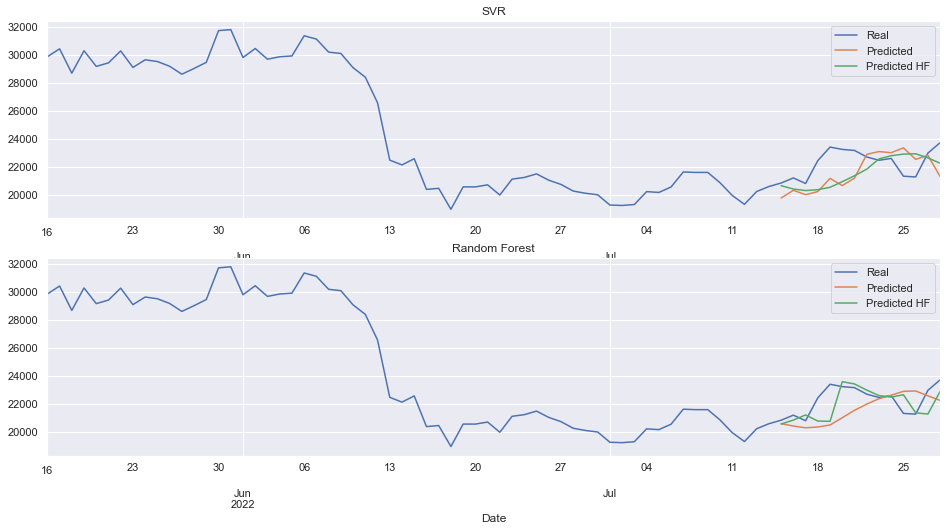

In [52]:
plot_df1 = pd.DataFrame(columns=["Real","Predicted","Predicted HF"])
plot_df1.Real = price.iloc[-(n+60):]
plot_df1.Predicted = np.nan
plot_df1["Predicted HF"] = np.nan
plot_df1.Predicted = pd.Series(pred_pr,index = price.iloc[-n:].index )
plot_df1["Predicted HF"] = pd.Series(pred_hf_price,index = price.iloc[-n:].index )
plot_df2 = pd.DataFrame(columns=["Real","Predicted","Predicted HF"])
plot_df2.Real = price.iloc[-(n+60):]
plot_df2.Predicted = np.nan
plot_df2["Predicted HF"] = np.nan
plot_df2.Predicted = pd.Series(base_p,index = price.iloc[-n:].index )
plot_df2["Predicted HF"] = pd.Series(base_p_hf,index = price.iloc[-n:].index )
fig, axes = plt.subplots(nrows=2,ncols=1)
plot_df1.plot(ax = axes[0],title="SVR") 
plot_df2.plot(ax = axes[1],title ="Random Forest")
plt.savefig("bit_svr.png", dpi=200)

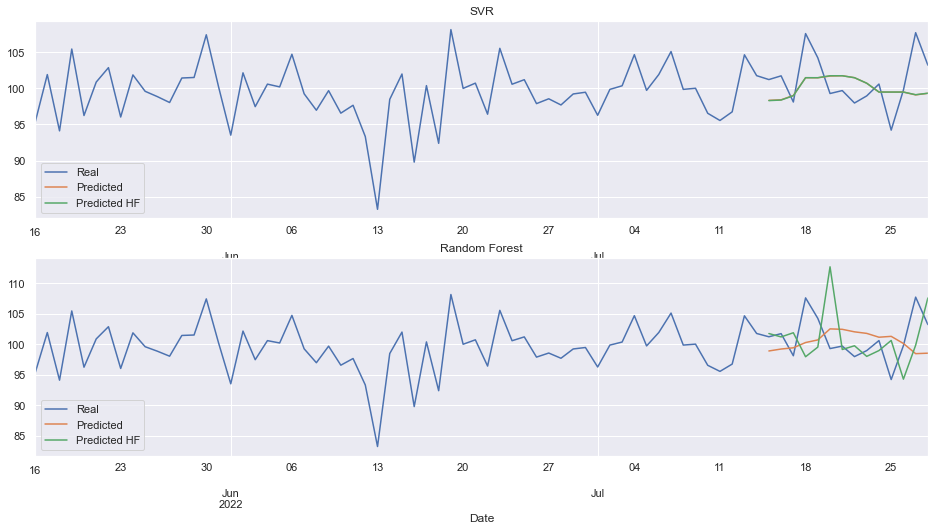

In [53]:
plot_df1 = pd.DataFrame(columns=["Real","Predicted","Predicted HF"])
plot_df1.Real = returns.iloc[-(n+60):]
plot_df1.Predicted = np.nan
plot_df1["Predicted HF"] = np.nan
plot_df1.Predicted = pd.Series(pred_r,index = price.iloc[-n:].index )
plot_df1["Predicted HF"] = pd.Series(pred_hf_return,index = price.iloc[-n:].index )
plot_df2 = pd.DataFrame(columns=["Real","Predicted","Predicted HF"])
plot_df2.Real = returns.iloc[-(n+60):]
plot_df2.Predicted = np.nan
plot_df2["Predicted HF"] = np.nan
plot_df2.Predicted = pd.Series(base_r,index = price.iloc[-n:].index )
plot_df2["Predicted HF"] = pd.Series(base_r_hf,index = price.iloc[-n:].index )
fig, axes = plt.subplots(nrows=2,ncols=1)
plot_df1.plot(ax = axes[0],title="SVR") 
plot_df2.plot(ax = axes[1],title ="Random Forest")
plt.savefig("bit_tr.png", dpi=200)

#### Conclusion

To summarize, two models SVR and RFR were analysed. The above analysis has provided some insights about both model performances under different circumstances.
One of the main insights was the importantce of high-frequancy data for the analysis as it improved all the scores and provided better prediction for the models.

Results of the analysis of both models in different marekt situation could be represented as follows:

Firstly, model SVR is more appropriate in the apperiance of high volatility of prices/returns, whereas the RFR model provided good measures in stable periods.

Secondly, RFR showed a better performance in terms of the metrcis and on the larger timescale.

#### Appendix

##### Additional factors

In [33]:
df["Hal"] = df.High-df.Low
df["Clope"]= df.Open-df.Close
df.head()

,Open,High,Low,Close,Volume,Return,Hal,Clope
Date,,,,,,,,
2021-01-01,29401.99,29412.84,29401.99,29412.84,9.920963,NaN,10.85,-10.85
2021-01-02,32186.27,32231.76,32224.18,32225.91,17.629130,0.091339,7.58,-39.64
2021-01-03,32984.58,33105.00,32999.71,33080.66,129.513002,0.026178,105.29,-96.08
2021-01-04,32008.00,32050.00,32039.99,32019.99,33.600088,-0.032588,10.01,-11.99
2021-01-05,33992.01,34062.46,33992.01,34030.64,14.525485,0.060901,70.45,-38.63


In [34]:
sample1 = df[["Close","Hal","Clope"]]
sample2 = df[["Return","Hal","Clope"]]

In [54]:
n=14  #time interval for the prediction/ choose such n that n%p == 0 
p=1 #three day prediction
d = 15 #number of rows in training sample 




# run the svr algos on daily data
pred_pr = sp.svr_retrain_mul(sample1,n=n,p=p,d=d,kernel='linear')
pred_r = sp.svr_retrain_mul(sample2,n=n,p=p,d=d,kernel='sigmoid')

#creating the dataframe containing all metrics 
df_metr = pd.DataFrame(columns = ["Price","Return"])
df_metr["Price"] = sp.metrics(pred_pr,price.iloc[-n:])[0]
df_metr["Return"] = sp.metrics(pred_r,returns.iloc[-n:])[0]
df_metr.T

100%|██████████| 14/14 [00:00<00:00, 463.59it/s]


,Mean Absolute Prct Error,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,(R squared) Score,Accuracy
Price,4.497,39579.0,2.233418e+09,47259.0,-0.2,-3.497
Return,17.856,108.0,1.166400e+04,108.0,-723.3,-16.856


<AxesSubplot:xlabel='Date'>

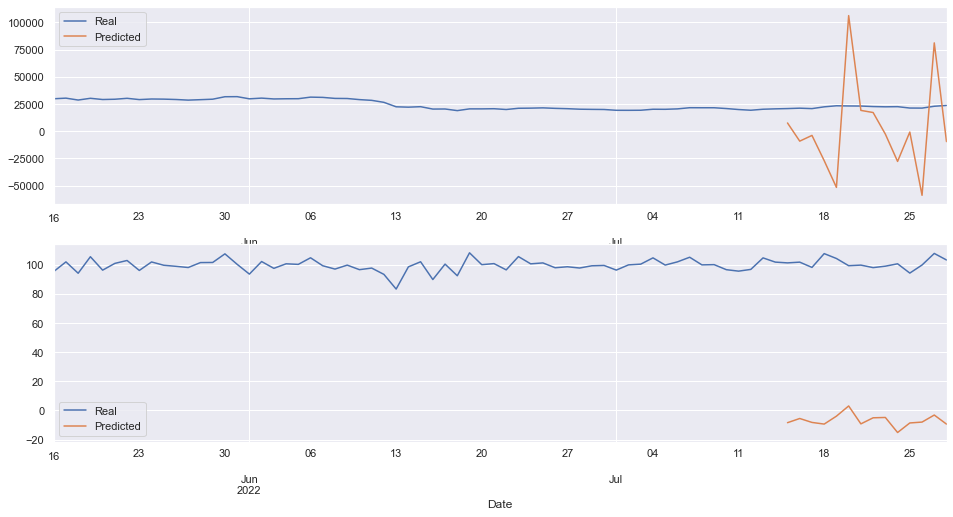

In [55]:
plot_df3 = pd.DataFrame(columns=["Real","Predicted"])
plot_df3.Real = price.iloc[-(n+60):]
plot_df3.Predicted = np.nan
plot_df3.Predicted = pd.Series(pred_pr,index = price.iloc[-n:].index )
plot_df4 = pd.DataFrame(columns=["Real","Predicted"])
plot_df4.Real = returns.iloc[-(n+60):]
plot_df4.Predicted = np.nan
plot_df4.Predicted = pd.Series(pred_r,index = price.iloc[-n:].index )
fig, axes = plt.subplots(nrows=2,ncols=1)
plot_df3.plot(ax = axes[0]) 
plot_df4.plot(ax = axes[1])

In [ ]:
n=14  #time interval for the prediction/ choose such n that n%p == 0 
p=1 #three day prediction
d = 15 #number of rows in training sample 




# run the random forest  algos on daily data
rfr_pred_pr = sp.rfr_hf(sample1,n=n,p=p,d=d)
rfr_pred_r = sp.rfr_hf(sample2,n=n,p=p,d=d)

#creating the dataframe containing all metrics 
df_metr = pd.DataFrame(columns = ["Price","Return"])
df_metr["Price"] = sp.metrics(pred_pr,price.iloc[-n:])[0]
df_metr["Return"] = sp.metrics(pred_r,returns.iloc[-n:])[0]
df_metr.T

Fitting 3 folds for each of 100 candidates, totalling 300 fits


100%|██████████| 14/14 [00:00<00:00, 32.30it/s]


Fitting 3 folds for each of 100 candidates, totalling 300 fits


<AxesSubplot:xlabel='Date'>

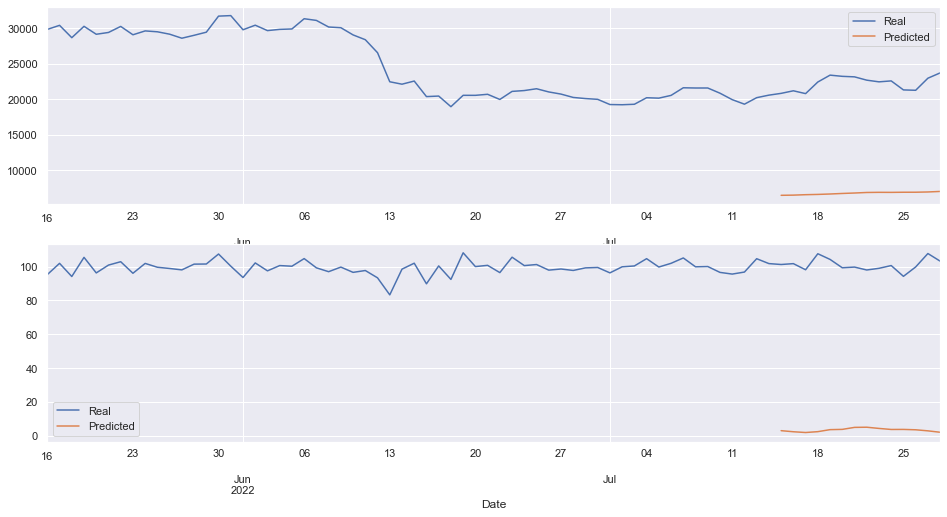

In [62]:
plot_df3 = pd.DataFrame(columns=["Real","Predicted"])
plot_df3.Real = price.iloc[-(n+60):]
plot_df3.Predicted = np.nan
plot_df3.Predicted = pd.Series(rfr_pred_pr,index = price.iloc[-n:].index )
plot_df4 = pd.DataFrame(columns=["Real","Predicted"])
plot_df4.Real = returns.iloc[-(n+60):]
plot_df4.Predicted = np.nan
plot_df4.Predicted = pd.Series(rfr_pred_r,index = price.iloc[-n:].index )
fig, axes = plt.subplots(nrows=2,ncols=1)
plot_df3.plot(ax = axes[0]) 
plot_df4.plot(ax = axes[1])